<a href="https://colab.research.google.com/github/cwilbar04/nba-predictions/blob/main/notebooks/model_data_creation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.colab import files
from datetime import datetime
import os
import pyarrow

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
my_project_id = "nba-predictions-dev"
raw_game_data_table = 'nba.raw_basketballreference_game'
raw_player_data_table = 'nba.raw_basketballreference_playerbox'

In [ ]:
# credentials = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")

In [19]:
client = bigquery.Client(project=my_project_id,)

In [12]:
game_table = bigquery.TableReference.from_string(
    f'{my_project_id}.{raw_game_data_table}'
)
rows = bqclient.list_rows(game_table)

In [14]:
rows

In [ ]:
%%bigquery --project nba-predictions-dev game
  SELECT * from `nba.raw_basketballreference_game`

In [ ]:
%%bigquery --project nba-predictions-dev player
  SELECT * from `nba.raw_basketballreference_playerbox`

In [243]:
game = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_game_data_table)).to_dataframe()

In [244]:
player = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_player_data_table)).to_dataframe()

In [245]:
game_original = game.copy()
player_original = player.copy()

In [128]:
game[game['game_date']==game['game_date'].max()]

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
16,2021-02-25,8:00p,Los Angeles Clippers,LAC,94,Memphis Grizzlies,MEM,122,/boxscores/202102250MEM.html,"1,896",,LAC20210225MEM800p,27,26,22,19,24,37,28,33,96.1,.476,13.3,16.3,.167,97.8,96.1,.603,5.7,17.5,.120,127.0,2021-02-26 12:00:17+00:00,None,None,None,None
17,2021-02-25,7:00p,Dallas Mavericks,DAL,97,Philadelphia 76ers,PHI,111,/boxscores/202102250PHI.html,0,,DAL20210225PHI700p,22,21,25,29,23,36,27,25,95.6,.494,17.0,24.4,.256,101.5,95.6,.500,6.5,16.7,.233,116.2,2021-02-26 12:00:15+00:00,None,None,None,None
18,2021-02-25,7:30p,Orlando Magic,ORL,92,Brooklyn Nets,BRK,129,/boxscores/202102250BRK.html,327,,ORL20210225BRK730p,28,19,25,20,24,41,27,37,104.2,.454,16.1,8.3,.149,88.3,104.2,.641,11.7,18.4,.120,123.7,2021-02-26 12:00:16+00:00,None,None,None,None
19,2021-02-25,7:30p,Sacramento Kings,SAC,121,New York Knicks,NYK,140,/boxscores/202102250NYK.html,"1,981",,SAC20210225NYK730p,29,33,32,27,38,39,24,39,103.5,.565,13.9,19.0,.294,116.9,103.5,.695,14.3,25.7,.218,135.3,2021-02-26 12:00:16+00:00,None,None,None,None
20,2021-02-25,9:00p,Washington Wizards,WAS,112,Denver Nuggets,DEN,110,/boxscores/202102250DEN.html,0,,WAS20210225DEN900p,26,30,32,24,22,32,34,22,97.1,.523,10.2,23.8,.256,115.4,97.1,.524,15.9,27.3,.247,113.3,2021-02-26 12:00:18+00:00,None,None,None,None
21,2021-02-25,9:30p,New Orleans Pelicans,NOP,125,Milwaukee Bucks,MIL,129,/boxscores/202102250MIL.html,"1,800",,NOP20210225MIL930p,31,37,35,22,35,34,34,26,102.5,.564,7.7,26.1,.098,121.9,102.5,.609,8.0,18.6,.125,125.9,2021-02-26 12:00:20+00:00,None,None,None,None


In [129]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
0,2021-01-18,5:00p,Phoenix Suns,PHO,104,Memphis Grizzlies,MEM,108,/boxscores/202101180MEM.html,204,,PHO20210118MEM500p,24,24,27,29,18,34,25,31,97.1,.540,15.9,27.9,.102,107.1,97.1,.560,14.0,22.0,.181,111.2,2021-02-24 21:26:16+00:00,None,None,None,None
1,2021-01-18,3:00p,San Antonio Spurs,SAS,125,Portland Trail Blazers,POR,104,/boxscores/202101180POR.html,0,,SAS20210118POR300p,32,27,28,38,28,26,28,22,97.4,.617,11.0,31.6,.156,128.3,97.4,.489,11.7,18.2,.178,106.7,2021-02-24 21:26:16+00:00,None,None,None,None
2,2021-01-18,7:30p,Dallas Mavericks,DAL,93,Toronto Raptors,TOR,116,/boxscores/202101180TOR.html,0,,DAL20210118TOR730p,18,29,25,21,22,25,34,35,98.7,.433,14.6,17.8,.268,94.2,98.7,.568,12.7,23.1,.182,117.5,2021-02-24 21:26:17+00:00,None,None,None,None
3,2021-01-18,7:30p,Milwaukee Bucks,MIL,123,Brooklyn Nets,BRK,125,/boxscores/202101180BRK.html,0,,MIL20210118BRK730p,34,22,33,34,28,29,37,31,104.1,.490,4.1,20.8,.190,118.2,104.1,.637,15.4,18.9,.214,120.1,2021-02-24 21:26:17+00:00,None,None,None,None
4,2021-01-18,10:00p,Golden State Warriors,GSW,115,Los Angeles Lakers,LAL,113,/boxscores/202101180LAL.html,0,,GSW20210118LAL1000p,22,26,33,34,34,30,28,21,100.3,.575,11.9,11.6,.172,114.6,100.3,.536,14.1,30.8,.289,112.6,2021-02-24 21:26:18+00:00,None,None,None,None


In [130]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,GSW20180106LAC330p,2018-01-06,a,GSW,game,Stephen Curry,/players/c/curryst01.html,curryst01,None,29:51,11,21,.524,8,16,.500,15,16,.938,2,4,6,3,3,0,2,2,45,+28,GSW20180106LAC330p|curryst01|game,True,2021-02-24 19:21:38+00:00
1,CLE20180106ORL700p,2018-01-06,h,ORL,game,Aaron Gordon,/players/g/gordoaa01.html,gordoaa01,None,31:38,13,26,.500,1,8,.125,3,6,.500,3,5,8,1,2,0,4,6,30,+2,CLE20180106ORL700p|gordoaa01|game,True,2021-02-24 19:21:42+00:00
2,CLE20180106ORL700p,2018-01-06,a,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,37:17,12,23,.522,4,7,.571,5,7,.714,3,7,10,9,6,1,3,1,33,+15,CLE20180106ORL700p|jamesle01|game,True,2021-02-24 19:21:42+00:00
3,MIL20180106WAS800p,2018-01-06,a,MIL,game,Giannis Antetokounmpo,/players/a/antetgi01.html,antetgi01,None,40:51,12,17,.706,1,1,1.000,9,10,.900,2,10,12,7,2,1,3,5,34,+14,MIL20180106WAS800p|antetgi01|game,True,2021-02-24 19:21:43+00:00
4,MIN20170106WAS700p,2017-01-06,a,MIN,game,Andrew Wiggins,/players/w/wiggian01.html,wiggian01,None,39:22,16,30,.533,1,3,.333,8,10,.800,1,0,1,2,2,0,2,2,41,-4,MIN20170106WAS700p|wiggian01|game,True,2021-02-24 17:24:02+00:00


In [131]:
game.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
count,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,7265,419,419,51,51
unique,1123,25,30,30,87,30,30,88,7100,3046,5,7100,43,40,44,44,42,44,44,42,317,363,212,328,400,613,317,366,208,333,410,618,5570,21,22,14,16
top,2017-02-15,8:00p,Boston Celtics,BOS,109,Golden State Warriors,GSW,104,/boxscores/201702100MIN.html,0,,CHI20170206SAC1030p,26,26,27,26,29,27,26,25,97.9,.500,10.3,25.0,.198,106.3,97.9,.500,13.0,20.0,.247,114.4,2021-02-24 21:15:02+00:00,12,9,9,9
freq,28,1659,269,269,242,275,275,252,2,351,6846,2,503,493,482,517,493,517,496,504,69,240,98,206,94,40,69,221,104,190,92,41,4,46,49,9,8
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-26 12:00:20+00:00,NaN,NaN,NaN,NaN


In [132]:
player.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
count,190851,190851,190851,190851,190851,190851,190851,190851,31621,159230,159230,159230,152054,159230,159230,115787,159230,159230,90496,159230,159230,159230,159230,159230,159230,159230,159230,159230,159198,190851,190851,190851
unique,7100,1123,2,30,1,1078,1078,1078,4,2932,25,45,258,15,25,92,25,31,126,16,24,30,25,10,12,13,7,64,100,180491,2,5891
top,DAL20170315WAS700p,2017-02-15,h,TOR,game,P.J. Tucker,/players/t/tuckepj01.html,tuckepj01,Did Not Play,12:00,1,5,.500,0,0,.000,0,0,1.000,0,1,2,0,0,0,0,1,0,0,NOP20170311CHO700p|couside01|game,False,2021-02-24 21:14:37+00:00
freq,52,720,95533,7011,190851,522,522,522,27559,463,22798,11751,20654,81350,43443,37907,74191,68734,40388,80424,27658,22229,44847,84938,109861,57382,39130,17169,6934,2,115791,104
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-26 12:00:20+00:00


In [325]:
game['home_spread'] = game['home_pts'].astype(int) - game['visitor_pts'].astype(int)

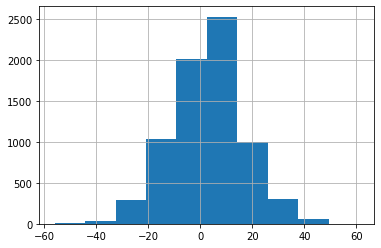

In [326]:
game['home_spread'].hist()

In [264]:
game['season'] = ''
for i in range(len(game)):
  if ((game['game_date'][i].year != 2020 and game['game_date'][i].month < 7) or (game['game_date'][i].year == 2020 and game['game_date'][i].month < 11)):
    game.loc[i,'season'] = game['game_date'][i].year
  else:
    game.loc[i,'season'] = game['game_date'][i].year + 1


In [265]:
game[game['season']=='']

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season


In [266]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,overtimes,game_key,a_g1_score,a_g2_score,a_g3_score,a_g4_score,h_g1_score,h_g2_score,h_g3_score,h_g4_score,a_ff_pace,a_ff_efg_pct,a_ff_tov_pct,a_ff_orb_pct,a_ff_ft_rate,a_ff_off_rtg,h_ff_pace,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season
0,2021-01-18,5:00p,Phoenix Suns,PHO,104,Memphis Grizzlies,MEM,108,/boxscores/202101180MEM.html,204,,PHO20210118MEM500p,24,24,27,29,18,34,25,31,97.1,.540,15.9,27.9,.102,107.1,97.1,.560,14.0,22.0,.181,111.2,2021-02-24 21:26:16+00:00,None,None,None,None,4,2021
1,2021-01-18,3:00p,San Antonio Spurs,SAS,125,Portland Trail Blazers,POR,104,/boxscores/202101180POR.html,0,,SAS20210118POR300p,32,27,28,38,28,26,28,22,97.4,.617,11.0,31.6,.156,128.3,97.4,.489,11.7,18.2,.178,106.7,2021-02-24 21:26:16+00:00,None,None,None,None,-21,2021
2,2021-01-18,7:30p,Dallas Mavericks,DAL,93,Toronto Raptors,TOR,116,/boxscores/202101180TOR.html,0,,DAL20210118TOR730p,18,29,25,21,22,25,34,35,98.7,.433,14.6,17.8,.268,94.2,98.7,.568,12.7,23.1,.182,117.5,2021-02-24 21:26:17+00:00,None,None,None,None,23,2021
3,2021-01-18,7:30p,Milwaukee Bucks,MIL,123,Brooklyn Nets,BRK,125,/boxscores/202101180BRK.html,0,,MIL20210118BRK730p,34,22,33,34,28,29,37,31,104.1,.490,4.1,20.8,.190,118.2,104.1,.637,15.4,18.9,.214,120.1,2021-02-24 21:26:17+00:00,None,None,None,None,2,2021
4,2021-01-18,10:00p,Golden State Warriors,GSW,115,Los Angeles Lakers,LAL,113,/boxscores/202101180LAL.html,0,,GSW20210118LAL1000p,22,26,33,34,34,30,28,21,100.3,.575,11.9,11.6,.172,114.6,100.3,.536,14.1,30.8,.289,112.6,2021-02-24 21:26:18+00:00,None,None,None,None,-2,2021


In [267]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   game_date          7265 non-null   object             
 1   game_start_time    7265 non-null   object             
 2   visitor_team_name  7265 non-null   object             
 3   away_abbr          7265 non-null   object             
 4   visitor_pts        7265 non-null   object             
 5   home_team_name     7265 non-null   object             
 6   home_abbr          7265 non-null   object             
 7   home_pts           7265 non-null   object             
 8   box_score_url      7265 non-null   object             
 9   attendance         7265 non-null   object             
 10  overtimes          7265 non-null   object             
 11  game_key           7265 non-null   object             
 12  a_g1_score         7265 non-null   object       

In [268]:
games_by_team_home = pd.DataFrame()
games_by_team_home['season'] = game['season']
games_by_team_home['game_key'] = game['game_key'] + 'h'
games_by_team_home['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_home['team'] = game['home_team_name']
games_by_team_home['opponent'] = game['visitor_team_name']
games_by_team_home['is_home_team'] = 1
games_by_team_home['spread'] = game['home_spread']
games_by_team_home['pace'] = game['h_ff_pace']
games_by_team_home['efg_pct'] = game['h_ff_efg_pct']
games_by_team_home['tov_pct'] = game['h_ff_tov_pct']
games_by_team_home['ft_rate'] = game['h_ff_ft_rate']
games_by_team_home['off_rtg'] = game['h_ff_off_rtg']
games_by_team_home['opponent_efg_pct'] = game['a_ff_efg_pct']
games_by_team_home['opponent_tov_pct'] = game['a_ff_tov_pct']
games_by_team_home['opponent_ft_rate'] = game['a_ff_ft_rate']
games_by_team_home['opponent_off_rtg'] = game['a_ff_off_rtg']


games_by_team_home['is_win'] = ''
for i in range(len(game)):
  games_by_team_home.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) > 0 else 0

In [269]:
games_by_team_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7265 non-null   object        
 1   game_key          7265 non-null   object        
 2   game_date         7265 non-null   datetime64[ns]
 3   team              7265 non-null   object        
 4   opponent          7265 non-null   object        
 5   is_home_team      7265 non-null   int64         
 6   spread            7265 non-null   int64         
 7   pace              7265 non-null   object        
 8   efg_pct           7265 non-null   object        
 9   tov_pct           7265 non-null   object        
 10  ft_rate           7265 non-null   object        
 11  off_rtg           7265 non-null   object        
 12  opponent_efg_pct  7265 non-null   object        
 13  opponent_tov_pct  7265 non-null   object        
 14  opponent_ft_rate  7265 n

In [141]:
games_by_team_visitor = pd.DataFrame()
games_by_team_visitor ['season'] = game['season']
games_by_team_visitor ['game_key'] = game['game_key'] + 'a'
games_by_team_visitor ['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_visitor ['team'] = game['visitor_team_name']
games_by_team_visitor ['opponent'] = game['home_team_name']
games_by_team_visitor ['is_home_team'] = 0
games_by_team_visitor ['spread'] = game['home_spread']*-1
games_by_team_visitor ['pace'] = game['a_ff_pace']
games_by_team_visitor ['efg_pct'] = game['a_ff_efg_pct']
games_by_team_visitor ['tov_pct'] = game['a_ff_tov_pct']
games_by_team_visitor ['ft_rate'] = game['a_ff_ft_rate']
games_by_team_visitor ['off_rtg'] = game['a_ff_off_rtg']
games_by_team_visitor['opponent_efg_pct'] = game['h_ff_efg_pct']
games_by_team_visitor['opponent_tov_pct'] = game['h_ff_tov_pct']
games_by_team_visitor['opponent_ft_rate'] = game['h_ff_ft_rate']
games_by_team_visitor['opponent_off_rtg'] = game['h_ff_off_rtg']

games_by_team_visitor['is_win'] = ''
for i in range(len(game)):
  games_by_team_visitor.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) < 0 else 0

In [270]:
games_by_team_visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7265 non-null   object        
 1   game_key          7265 non-null   object        
 2   game_date         7265 non-null   datetime64[ns]
 3   team              7265 non-null   object        
 4   opponent          7265 non-null   object        
 5   home?             7265 non-null   int64         
 6   spread            7265 non-null   int64         
 7   pace              7265 non-null   object        
 8   efg_pct           7265 non-null   object        
 9   tov_pct           7265 non-null   object        
 10  ft_rate           7265 non-null   object        
 11  off_rtg           7265 non-null   object        
 12  opponent_efg_pct  7265 non-null   object        
 13  opponent_tov_pct  7265 non-null   object        
 14  opponent_ft_rate  7265 n

In [271]:
games_by_team = pd.concat([games_by_team_home,games_by_team_visitor])

In [272]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14530 entries, 0 to 7264
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14530 non-null  object        
 1   game_key          14530 non-null  object        
 2   game_date         14530 non-null  datetime64[ns]
 3   team              14530 non-null  object        
 4   opponent          14530 non-null  object        
 5   is_home_team      7265 non-null   float64       
 6   spread            14530 non-null  int64         
 7   pace              14530 non-null  object        
 8   efg_pct           14530 non-null  object        
 9   tov_pct           14530 non-null  object        
 10  ft_rate           14530 non-null  object        
 11  off_rtg           14530 non-null  object        
 12  opponent_efg_pct  14530 non-null  object        
 13  opponent_tov_pct  14530 non-null  object        
 14  opponent_ft_rate  14530

In [273]:
games_by_team[games_by_team['is_win']=='']

,season,game_key,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result


In [274]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,GSW20180106LAC330p,2018-01-06,a,GSW,game,Stephen Curry,/players/c/curryst01.html,curryst01,None,29:51,11,21,.524,8,16,.500,15,16,.938,2,4,6,3,3,0,2,2,45,+28,GSW20180106LAC330p|curryst01|game,True,2021-02-24 19:21:38+00:00
1,CLE20180106ORL700p,2018-01-06,h,ORL,game,Aaron Gordon,/players/g/gordoaa01.html,gordoaa01,None,31:38,13,26,.500,1,8,.125,3,6,.500,3,5,8,1,2,0,4,6,30,+2,CLE20180106ORL700p|gordoaa01|game,True,2021-02-24 19:21:42+00:00
2,CLE20180106ORL700p,2018-01-06,a,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,37:17,12,23,.522,4,7,.571,5,7,.714,3,7,10,9,6,1,3,1,33,+15,CLE20180106ORL700p|jamesle01|game,True,2021-02-24 19:21:42+00:00
3,MIL20180106WAS800p,2018-01-06,a,MIL,game,Giannis Antetokounmpo,/players/a/antetgi01.html,antetgi01,None,40:51,12,17,.706,1,1,1.000,9,10,.900,2,10,12,7,2,1,3,5,34,+14,MIL20180106WAS800p|antetgi01|game,True,2021-02-24 19:21:43+00:00
4,MIN20170106WAS700p,2017-01-06,a,MIN,game,Andrew Wiggins,/players/w/wiggian01.html,wiggian01,None,39:22,16,30,.533,1,3,.333,8,10,.800,1,0,1,2,2,0,2,2,41,-4,MIN20170106WAS700p|wiggian01|game,True,2021-02-24 17:24:02+00:00


In [275]:
player['game_key'] = player['game_key'] + player['h_or_a']

In [276]:
player = player.dropna(subset=['mp', 'plus_minus']).reset_index(drop=True)

In [277]:
player['plus_minus'] = player['plus_minus'].astype(int)

In [278]:
def convert_to_seconds(x):
  sp = int(x.split(':')[0]) * 60 + int(x.split(':')[1])
  return sp

In [279]:
player['seconds_played'] = player['mp'].apply(convert_to_seconds)

In [280]:
player['seconds_played'] = player['seconds_played'].astype(int)

In [281]:
game_player_stats = pd.DataFrame()
game_player_stats['game_key'] = player['game_key'].unique()

In [282]:
game_player_stats.head()

,game_key
0,GSW20180106LAC330pa
1,CLE20180106ORL700ph
2,CLE20180106ORL700pa
3,MIL20180106WAS800pa
4,MIN20170106WAS700pa


In [283]:
a = player.groupby(['game_key'])['seconds_played'].sum()

In [284]:
b = player[player['starter_flag']==True].groupby(['game_key'])['seconds_played'].sum()

In [285]:
seconds = pd.merge(a, b, left_index=True, right_index=True, how='inner')

In [286]:
seconds['starter_minutes_played_proportion'] = seconds['seconds_played_y']/seconds['seconds_played_x']

In [287]:
seconds.head()

,seconds_played_x,seconds_played_y,starter_minutes_played_proportion
game_key,,,
ATL20150307PHI730pa,14400,8553,0.593958
ATL20150307PHI730ph,14400,8817,0.612292
ATL20150311DEN900pa,14400,7150,0.496528
ATL20150311DEN900ph,14400,7053,0.489792
ATL20150313PHO1000pa,14400,10095,0.701042


In [288]:
game_player_stats.set_index('game_key',inplace=True)

In [289]:
game_player_stats = pd.merge(game_player_stats,seconds['starter_minutes_played_proportion'],left_index=True,right_index=True,how='inner')

In [290]:
game_player_stats.head()

,starter_minutes_played_proportion
game_key,
GSW20180106LAC330pa,0.502083
CLE20180106ORL700ph,0.679028
CLE20180106ORL700pa,0.583889
MIL20180106WAS800pa,0.757431
MIN20170106WAS700pa,0.785694


In [291]:
bench_pl_min = player[player['starter_flag']==False].groupby(['game_key'])['plus_minus'].sum()

In [292]:
game_player_stats = pd.merge(game_player_stats,bench_pl_min, left_index=True, right_index=True, how='inner')

In [293]:
game_player_stats = game_player_stats.rename(columns={'plus_minus':'bench_plus_minus'})

In [294]:
game_player_stats.head()

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
GSW20180106LAC330pa,0.502083,-30
CLE20180106ORL700ph,0.679028,-1
CLE20180106ORL700pa,0.583889,-51
MIL20180106WAS800pa,0.757431,19
MIN20170106WAS700pa,0.785694,-7


In [295]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14530 entries, 0 to 7264
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14530 non-null  object        
 1   game_key          14530 non-null  object        
 2   game_date         14530 non-null  datetime64[ns]
 3   team              14530 non-null  object        
 4   opponent          14530 non-null  object        
 5   is_home_team      7265 non-null   float64       
 6   spread            14530 non-null  int64         
 7   pace              14530 non-null  object        
 8   efg_pct           14530 non-null  object        
 9   tov_pct           14530 non-null  object        
 10  ft_rate           14530 non-null  object        
 11  off_rtg           14530 non-null  object        
 12  opponent_efg_pct  14530 non-null  object        
 13  opponent_tov_pct  14530 non-null  object        
 14  opponent_ft_rate  14530

In [296]:
games_by_team.set_index('game_key', inplace=True)

In [297]:
games_by_team = pd.merge(games_by_team,game_player_stats, left_index=True, right_index=True,how='inner')

In [298]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result,starter_minutes_played_proportion,bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,NaN,-8,97.1,.461,18.4,.169,86.5,.437,13.5,.095,94.8,NaN,0.0,0,0.593958,-4
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1.0,8,97.1,.437,13.5,.095,94.8,.461,18.4,.169,86.5,1,NaN,NaN,0.612292,2
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,NaN,-13,97.9,.475,15.5,.309,104.2,.577,17.0,.214,117.4,NaN,0.0,0,0.496528,6
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1.0,13,97.9,.577,17.0,.214,117.4,.475,15.5,.309,104.2,1,NaN,NaN,0.489792,-21
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,NaN,9,91.1,.518,11.1,.120,105.3,.474,17.1,.167,95.5,NaN,0.0,1,0.701042,34


In [299]:
game_player_stats

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
GSW20180106LAC330pa,0.502083,-30
CLE20180106ORL700ph,0.679028,-1
CLE20180106ORL700pa,0.583889,-51
MIL20180106WAS800pa,0.757431,19
MIN20170106WAS700pa,0.785694,-7
...,...,...
MIA20191214DAL830pa,0.642659,-9
HOU20161116OKC800pa,0.718958,-1
ORL20191215NOP330pa,0.638194,37


In [300]:
game_player_stats_opponent = game_player_stats.copy()

In [301]:
game_player_stats_opponent.reset_index(drop=False, inplace=True)

In [302]:
def switch_key(key):
  new_key = key[:-1] + ('h' if key[-1] == 'a' else 'a')
  return new_key

In [303]:
game_player_stats_opponent['game_key'] = game_player_stats_opponent['game_key'].apply(switch_key)

In [304]:
game_player_stats_opponent = game_player_stats_opponent.rename(columns={'starter_minutes_played_proportion':'opponnent_starter_minutes_played_proportion','bench_plus_minus':'opponent_bench_plus_minus'})

In [305]:
game_player_stats_opponent.set_index('game_key', inplace=True)

In [306]:
games_by_team = pd.merge(games_by_team,game_player_stats_opponent,left_index=True,right_index=True,how='inner')

In [307]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,NaN,-8,97.1,.461,18.4,.169,86.5,.437,13.5,.095,94.8,NaN,0.0,0,0.593958,-4,0.612292,2
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1.0,8,97.1,.437,13.5,.095,94.8,.461,18.4,.169,86.5,1,NaN,NaN,0.612292,2,0.593958,-4
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,NaN,-13,97.9,.475,15.5,.309,104.2,.577,17.0,.214,117.4,NaN,0.0,0,0.496528,6,0.489792,-21
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1.0,13,97.9,.577,17.0,.214,117.4,.475,15.5,.309,104.2,1,NaN,NaN,0.489792,-21,0.496528,6
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,NaN,9,91.1,.518,11.1,.120,105.3,.474,17.1,.167,95.5,NaN,0.0,1,0.701042,34,0.720694,-31


In [308]:
games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)]

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,NaN,-19,113.5,.511,19.7,.167,94.3,.515,11.8,.242,111.0,NaN,0.0,0,0.587986,-45,0.523958,49
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,NaN,-14,106.0,.578,16.1,.253,110.4,.623,13.8,.370,123.6,NaN,0.0,0,0.519444,-26,0.495208,-49
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,NaN,22,106.0,.602,10.1,.153,125.5,.515,14.6,.091,104.7,NaN,0.0,1,0.585069,57,0.642569,-79
ATL20181029PHI700pa,2019,2018-10-29,Atlanta Hawks,Philadelphia 76ers,NaN,-21,105.5,.415,11.2,.149,87.2,.485,15.1,.172,107.1,NaN,0.0,0,0.508819,-39,0.579722,39
ATL20181030CLE700pa,2019,2018-10-30,Atlanta Hawks,Cleveland Cavaliers,NaN,-22,105.7,.628,19.7,.134,107.8,.572,10.7,.367,128.6,NaN,0.0,0,0.566806,-14,0.595486,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOR20181121ATL730ph,2019,2018-11-21,Atlanta Hawks,Toronto Raptors,1.0,-16,99.7,.505,8.2,.151,108.3,.594,14.5,.189,124.3,0,NaN,NaN,0.498333,4,0.660764,-18
TOR20190207ATL730ph,2019,2019-02-07,Atlanta Hawks,Toronto Raptors,1.0,-18,96.9,.550,15.7,.163,104.2,.534,7.3,.299,122.7,0,NaN,NaN,0.625139,-1,0.697083,34
UTA20190321ATL730ph,2019,2019-03-21,Atlanta Hawks,Utah Jazz,1.0,3,102.8,.580,14.1,.184,113.8,.511,12.5,.191,110.9,1,NaN,NaN,0.631597,13,0.645208,-18


In [309]:
def generate_streak_info(data,column):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate streak data

    column:
      Stirng with specific column name to generate streak info

    Returns
    -------

    data_with_streak_counter:
        The original dataframe with a new column
        `streak_counter_[column]` containing integers with 
        counts for each streak.
    """
    
    data['start_of_streak'] = data[column].ne(data[column].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data[f'streak_counter_{column}'] = data.groupby('streak_id').cumcount() + 1
    data_with_streak_counter = data.drop(columns = ['start_of_streak','streak_id'] )
    return data_with_streak_counter

In [310]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])
testing2 = games_by_team.loc[(games_by_team['team']=='Washington Wizards') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [311]:
testing = generate_streak_info(testing,'is_win')
testing2 = generate_streak_info(testing2,'is_win')

In [312]:
# Make negative streak if losing streak, positive if winning streak
testing['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing['streak_counter_is_win'],testing['is_win'])]
testing['incoming_is_win_streak'] = testing['streak_counter_is_win'].shift(fill_value=0)
testing2['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing2['streak_counter_is_win'],testing2['is_win'])]
testing2['incoming_is_win_streak'] = testing2['streak_counter_is_win'].shift(fill_value=0)


In [185]:
test = pd.concat([testing, testing2])

In [186]:
test.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak
game_key,,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,.167,94.3,.515,11.8,.242,111.0,0,0.587986,-45,0.523958,49,-1,0
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,.253,110.4,.623,13.8,.370,123.6,0,0.519444,-26,0.495208,-49,-2,-1
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,.153,125.5,.515,14.6,.091,104.7,1,0.585069,57,0.642569,-79,1,-2
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,.489,12.5,.242,102.7,.484,14.2,.176,96.2,1,0.611806,2,0.677431,39,2,1
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,.393,18.9,.226,83.6,.506,18.2,.157,95.3,0,0.566250,25,0.540833,49,-1,2


In [187]:
test.loc[(test['team']=='Washington Wizards') & (test['season']==2019)]

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_result,incoming_result_streak
game_key,,,,,,,,,,,,,,,,,,,,,,
MIA20181018WAS800ph,2019,2018-10-18,Washington Wizards,Miami Heat,1,-1,101.9,.512,12.5,.358,109.9,.454,12.5,.258,110.8,0,0.554514,-8,0.652639,13,-1,0
TOR20181020WAS700ph,2019,2018-10-20,Washington Wizards,Toronto Raptors,1,-4,102.0,.489,9.6,.292,110.7,.500,14.1,.330,114.7,0,0.596111,-44,0.570972,-7,-2,-1
WAS20181022POR1000pa,2019,2018-10-22,Washington Wizards,Portland Trail Blazers,0,1,107.4,.486,7.6,.164,105.4,.449,13.5,.250,104.6,1,0.592327,0,0.598113,-2,1,-2
WAS20181024GSW1030pa,2019,2018-10-24,Washington Wizards,Golden State Warriors,0,-22,106.7,.516,10.2,.280,114.3,.658,12.7,.250,134.9,0,0.433194,-49,0.551528,32,-1,1
WAS20181026SAC1000pa,2019,2018-10-26,Washington Wizards,Sacramento Kings,0,-4,108.9,.547,17.9,.209,102.8,.537,14.6,.147,106.5,0,0.636111,11,0.635000,-48,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAS20190331DEN800pa,2019,2019-03-31,Washington Wizards,Denver Nuggets,0,5,99.6,.435,9.0,.163,95.4,.414,9.8,.140,90.4,1,0.738333,12,0.609514,-31,1,-1
CHI20190403WAS700ph,2019,2019-04-03,Washington Wizards,Chicago Bulls,1,-1,107.8,.490,10.0,.196,105.7,.561,17.0,.156,106.7,0,0.609514,0,0.538403,11,-1,1
SAS20190405WAS700ph,2019,2019-04-05,Washington Wizards,San Antonio Spurs,1,-17,94.3,.528,8.4,.216,118.8,.615,8.3,.187,136.8,0,0.655694,-48,0.585556,16,-2,-1


In [188]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [189]:
testing['pace'].unique()

array(['113.5', '106.0', '108.1', '101.7', '105.5', '105.7', '112.9',
       '100.5', '108.0', '101.5', '102.9', '103.9', '96.8', '106.2',
       '107.4', '107.1', '99.7', '106.6', '101.6', '106.7', '104.0',
       '107.5', '110.6', '101.3', '106.5', '101.2', '102.8', '100.6',
       '101.8', '102.3', '99.8', '96.9', '99.6', '112.3', '97.3', '103.8',
       '104.8', '98.1', '110.2', '104.9', '101.1', '99.3', '97.8', '98.0',
       '105.2', '105.4', '100.4', '98.2', '95.7', '111.4', '97.0', '96.2',
       '100.8', '102.6', '97.6', '104.4', '104.6', '103.0', '98.7',
       '105.9', '100.9', '110.9', '107.7'], dtype=object)

In [190]:
testing['pace'] = testing['pace'].astype(float)

In [191]:
# Set W to number of days desired for moving average
W = 10
weights = np.arange(1,W+1)

In [192]:
testing['pace'].rolling(10).apply(lambda pace: np.dot(pace, weights)/weights.sum(), raw=True)

game_key
ATL20181017NYK730pa           NaN
ATL20181019MEM800pa           NaN
ATL20181021CLE600pa           NaN
DAL20181024ATL700ph           NaN
CHI20181027ATL730ph           NaN
                          ...    
ATL20190402SAS830pa    104.201818
PHI20190403ATL730ph    103.758182
ATL20190405ORL700pa    105.016364
ATL20190407MIL700pa    105.614545
IND20190410ATL800ph    106.127273
Name: pace, Length: 82, dtype: float64

In [313]:
def create_linear_weighted_moving_average(data,column,W):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate weighted moving average.

    column:
      Stirng with specific column name to generate weighted moving average info.
      Column must be ready to be converted to float data type.

    Returns
    -------

    data_with_moving_average:
        The original dataframe with a new column
        `wma_[W]_[column]` containing float values with weighted moving average
        values for the provided value with a weight of W.
    """  
    data_with_moving_average = data.copy()
    data_with_moving_average[column] = data_with_moving_average[column].astype(float)
    weights = np.arange(1,W+1) 
    data_with_moving_average[f'wma_{W}_{column}'] = data_with_moving_average[column].rolling(W).apply(lambda col: np.dot(col, weights)/weights.sum(), raw=True)
    return data_with_moving_average

In [194]:
testing4 = create_linear_weighted_moving_average(testing,'efg_pct',10)

In [195]:
testing4 = create_linear_weighted_moving_average(testing4,'bench_plus_minus',10)

In [196]:
testing4.head()

,season,game_date,team,opponent,home?,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,wma_10_efg_pct,wma_10_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,0.511,19.7,.167,94.3,.515,11.8,.242,111.0,0,0.587986,-45.0,0.523958,49,NaN,NaN
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,0.578,16.1,.253,110.4,.623,13.8,.370,123.6,0,0.519444,-26.0,0.495208,-49,NaN,NaN
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,0.602,10.1,.153,125.5,.515,14.6,.091,104.7,1,0.585069,57.0,0.642569,-79,NaN,NaN
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,0.489,12.5,.242,102.7,.484,14.2,.176,96.2,1,0.611806,2.0,0.677431,39,NaN,NaN
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,0.393,18.9,.226,83.6,.506,18.2,.157,95.3,0,0.566250,25.0,0.540833,49,NaN,NaN


In [314]:
games_by_team_with_streak = pd.DataFrame()
wma_columns = ['pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus']
W = 10
for team in games_by_team['team'].unique():
  team_games = games_by_team.loc[games_by_team['team']==team].sort_values(by='game_date')
  team_games = generate_streak_info(team_games,'is_win')
  team_games['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(team_games['streak_counter_is_win'],team_games['is_win'])]
  team_games['incoming_is_win_streak'] = team_games['streak_counter_is_win'].shift()
  for col in wma_columns:
    team_games = create_linear_weighted_moving_average(team_games,col,W)
    team_games[f'incoming_wma_{W}_{col}'] = team_games[f'wma_{W}_{col}'].shift()
  games_by_team_with_streak = pd.concat([games_by_team_with_streak, team_games])

In [315]:
games_by_team = games_by_team_with_streak.copy()

In [316]:
games_by_team.head(12)

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak,wma_10_pace,incoming_wma_10_pace,wma_10_efg_pct,incoming_wma_10_efg_pct,wma_10_tov_pct,incoming_wma_10_tov_pct,wma_10_ft_rate,incoming_wma_10_ft_rate,wma_10_off_rtg,incoming_wma_10_off_rtg,wma_10_opponent_efg_pct,incoming_wma_10_opponent_efg_pct,wma_10_opponent_tov_pct,incoming_wma_10_opponent_tov_pct,wma_10_opponent_ft_rate,incoming_wma_10_opponent_ft_rate,wma_10_opponent_off_rtg,incoming_wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,incoming_wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,incoming_wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,incoming_wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus,incoming_wma_10_opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOU20150303ATL730ph,2015,2015-03-03,Atlanta Hawks,Houston Rockets,1.0,8,97.6,0.500,13.6,0.209,106.6,0.511,11.3,0.044,98.4,1,NaN,NaN,0.692431,-22.0,0.724028,-6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLE20150306ATL730ph,2015,2015-03-06,Atlanta Hawks,Cleveland Cavaliers,1.0,9,88.9,0.548,11.6,0.167,119.3,0.514,16.9,0.377,109.2,1,NaN,NaN,0.672431,30.0,0.699583,-35.0,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,NaN,-8,97.1,0.461,18.4,0.169,86.5,0.437,13.5,0.095,94.8,NaN,0.0,0,0.593958,-4.0,0.612292,2.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAC20150309ATL730ph,2015,2015-03-09,Atlanta Hawks,Sacramento Kings,1.0,25,89.7,0.716,12.5,0.045,145.0,0.531,15.1,0.235,117.1,1,NaN,NaN,0.616902,39.0,0.582083,-46.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,NaN,-13,97.9,0.475,15.5,0.309,104.2,0.577,17.0,0.214,117.4,NaN,0.0,0,0.496528,6.0,0.489792,-21.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,NaN,9,91.1,0.518,11.1,0.120,105.3,0.474,17.1,0.167,95.5,NaN,0.0,1,0.701042,34.0,0.720694,-31.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150315LAL930pa,2015,2015-03-15,Atlanta Hawks,Los Angeles Lakers,NaN,5,89.4,0.480,10.2,0.237,101.8,0.441,18.7,0.129,96.2,NaN,0.0,1,0.600945,8.0,0.515347,18.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150316SAC1000pa,2015,2015-03-16,Atlanta Hawks,Sacramento Kings,NaN,7,99.3,0.524,11.0,0.262,110.8,0.512,17.9,0.247,103.8,NaN,0.0,1,0.670347,-6.0,0.575069,8.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150318GSW1030pa,2015,2015-03-18,Atlanta Hawks,Golden State Warriors,NaN,-19,97.3,0.402,13.0,0.287,97.6,0.607,16.2,0.143,117.1,NaN,0.0,0,0.607014,-22.0,0.557153,52.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
games_by_team.columns

Index(['season', 'game_date', 'team', 'opponent', 'is_home_team', 'spread',
       'pace', 'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg', 'opponent_efg_pct',
       'opponent_tov_pct', 'opponent_ft_rate', 'opponent_off_rtg', 'is_win',
       'home?', 'result', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus', 'streak_counter_is_win',
       'incoming_is_win_streak', 'wma_10_pace', 'incoming_wma_10_pace',
       'wma_10_efg_pct', 'incoming_wma_10_efg_pct', 'wma_10_tov_pct',
       'incoming_wma_10_tov_pct', 'wma_10_ft_rate', 'incoming_wma_10_ft_rate',
       'wma_10_off_rtg', 'incoming_wma_10_off_rtg', 'wma_10_opponent_efg_pct',
       'incoming_wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'incoming_wma_10_opponent_tov_pct', 'wma_10_opponent_ft_rate',
       'incoming_wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'incoming_wma_10_opponent_off_rtg',
       'wma_10_st

In [318]:
model_game_data = games_by_team.copy()

In [319]:
model_game_data.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,home?,result,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak,wma_10_pace,incoming_wma_10_pace,wma_10_efg_pct,incoming_wma_10_efg_pct,wma_10_tov_pct,incoming_wma_10_tov_pct,wma_10_ft_rate,incoming_wma_10_ft_rate,wma_10_off_rtg,incoming_wma_10_off_rtg,wma_10_opponent_efg_pct,incoming_wma_10_opponent_efg_pct,wma_10_opponent_tov_pct,incoming_wma_10_opponent_tov_pct,wma_10_opponent_ft_rate,incoming_wma_10_opponent_ft_rate,wma_10_opponent_off_rtg,incoming_wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,incoming_wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,incoming_wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,incoming_wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus,incoming_wma_10_opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOU20150303ATL730ph,2015,2015-03-03,Atlanta Hawks,Houston Rockets,1.0,8,97.6,0.500,13.6,0.209,106.6,0.511,11.3,0.044,98.4,1,NaN,NaN,0.692431,-22.0,0.724028,-6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLE20150306ATL730ph,2015,2015-03-06,Atlanta Hawks,Cleveland Cavaliers,1.0,9,88.9,0.548,11.6,0.167,119.3,0.514,16.9,0.377,109.2,1,NaN,NaN,0.672431,30.0,0.699583,-35.0,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,NaN,-8,97.1,0.461,18.4,0.169,86.5,0.437,13.5,0.095,94.8,NaN,0.0,0,0.593958,-4.0,0.612292,2.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAC20150309ATL730ph,2015,2015-03-09,Atlanta Hawks,Sacramento Kings,1.0,25,89.7,0.716,12.5,0.045,145.0,0.531,15.1,0.235,117.1,1,NaN,NaN,0.616902,39.0,0.582083,-46.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,NaN,-13,97.9,0.475,15.5,0.309,104.2,0.577,17.0,0.214,117.4,NaN,0.0,0,0.496528,6.0,0.489792,-21.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
model_game_data = games_by_team.dropna(subset=['incoming_wma_10_pace'])

In [321]:
model_game_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14230 entries, SAS20150322ATL300ph to WAS20210225DEN900pa
Data columns (total 50 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   season                                                       14230 non-null  object        
 1   game_date                                                    14230 non-null  datetime64[ns]
 2   team                                                         14230 non-null  object        
 3   opponent                                                     14230 non-null  object        
 4   is_home_team                                                 7117 non-null   float64       
 5   spread                                                       14230 non-null  int64         
 6   pace                                                         14230 non-null  float6

In [322]:
model_game_data['is_win'].unique()

array([0, nan, 1], dtype=object)

In [323]:
model_game_data['season'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=object)

In [324]:
model_game_data = model_game_data.astype({'season': int, 'is_win': int})

ValueError: ignored

In [246]:
model_game_data.reset_index(drop=False,inplace=True)

In [255]:
model_game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14230 entries, 0 to 14229
Data columns (total 49 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   game_key                                                     14230 non-null  object        
 1   season                                                       14230 non-null  int64         
 2   game_date                                                    14230 non-null  datetime64[ns]
 3   team                                                         14230 non-null  object        
 4   opponent                                                     14230 non-null  object        
 5   home?                                                        14230 non-null  int64         
 6   spread                                                       14230 non-null  int64         
 7   pace         

In [254]:
model_game_data.columns

Index(['game_key', 'season', 'game_date', 'team', 'opponent', 'home?',
       'spread', 'pace', 'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'result', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus', 'streak_counter_result',
       'incoming_result_streak', 'wma_10_pace', 'incoming_wma_10_pace',
       'wma_10_efg_pct', 'incoming_wma_10_efg_pct', 'wma_10_tov_pct',
       'incoming_wma_10_tov_pct', 'wma_10_ft_rate', 'incoming_wma_10_ft_rate',
       'wma_10_off_rtg', 'incoming_wma_10_off_rtg', 'wma_10_opponent_efg_pct',
       'incoming_wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'incoming_wma_10_opponent_tov_pct', 'wma_10_opponent_ft_rate',
       'incoming_wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'incoming_wma_10_opponent_off_rtg',
       'wma_10_starter_minutes_

In [259]:
%env GOOGLE_CLOUD_PROJECT nba-predictions-dev

env: GOOGLE_CLOUD_PROJECT=nba-predictions-dev


In [260]:
client = bigquery.Client(project=my_project_id)

In [261]:

#Publish model data
job_config = bigquery.LoadJobConfig()
job_config.autodetect='True'
job_config.create_disposition = 'CREATE_IF_NEEDED'
job_config.write_disposition = 'WRITE_APPEND'
job_config.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="game_date")
## Set schema for specific columns where more information is needed (e.g. not NULLABLE or specific date/time)
job_config.schema = [
    bigquery.SchemaField('game_key','STRING', 'REQUIRED'),
    bigquery.SchemaField('team','STRING', 'REQUIRED'),
    bigquery.SchemaField('opponent','STRING', 'REQUIRED'),
]
job_model = client.load_table_from_dataframe(model_game_data, 'nba.model_game', job_config=job_config)


BadRequest: ignored

In [ ]:
#Publish model data
job_config = bigquery.LoadJobConfig()
job_config.autodetect='True'
job_config.create_disposition = 'CREATE_IF_NEEDED'
job_config.write_disposition = 'WRITE_APPEND'
job_config.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="game_date")
## Set schema for specific columns where more information is needed (e.g. not NULLABLE or specific date/time)
job_config.schema = [
    bigquery.SchemaField('game_key','STRING', 'REQUIRED')
]
job_model = client.load_table_from_dataframe(model_game_data, 'nba.model_game', job_config=job_config)

In [253]:
%%bash
  gcloud config set project nba-predictions-dev

Updated property [core/project].


In [ ]:
model_result = job_model.result()
model_message = (
    f'Job ID: {model_result.job_id} '
    f'was started {model_result.started} '
    f'and ended {model_result.ended} '
    f'loading {model_result.output_rows} row(s) '
    f'to {model_result.destination}')
print(model_result)

In [232]:
a = model_game_data.groupby('team').max('game_date')

In [235]:
most_recent_game = model_game_data.sort_values('game_date').drop_duplicates(['team'],keep='last')

In [236]:
most_recent_game = most_recent_game[['season', 'game_date', 'team','streak_counter_is_win',
       'wma_10_pace', 'wma_10_efg_pct', 'wma_10_tov_pct', 'wma_10_ft_rate',
       'wma_10_off_rtg', 'wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'wma_10_starter_minutes_played_proportion', 'wma_10_bench_plus_minus',
       'wma_10_opponnent_starter_minutes_played_proportion',
       'wma_10_opponent_bench_plus_minus']]

In [238]:
most_recent_game.reset_index(drop=True, inplace=True)

In [239]:
most_recent_game

,season,game_date,team,streak_counter_result,wma_10_pace,wma_10_efg_pct,wma_10_tov_pct,wma_10_ft_rate,wma_10_off_rtg,wma_10_opponent_efg_pct,wma_10_opponent_tov_pct,wma_10_opponent_ft_rate,wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus
0,2021,2021-02-23,Portland Trail Blazers,-3,96.189091,0.543255,10.492727,0.170291,117.481818,0.535636,8.396364,0.224491,121.429091,0.671654,-16.127273,0.607620,27.127273
1,2021,2021-02-24,Golden State Warriors,2,101.427273,0.539964,12.581818,0.202182,111.160000,0.520618,14.465455,0.185600,106.460000,0.643475,11.454545,0.633497,-2.600000
2,2021,2021-02-24,Phoenix Suns,-1,96.803636,0.619345,9.592727,0.160236,128.405455,0.535036,11.350909,0.227600,113.861818,0.585312,31.963636,0.613234,-27.727273
3,2021,2021-02-24,Los Angeles Lakers,-4,97.812727,0.515982,14.074545,0.175618,104.609091,0.544509,12.220000,0.181782,111.345455,0.597917,-13.290909,0.648540,4.254545
4,2021,2021-02-24,Atlanta Hawks,1,96.618182,0.564145,11.661818,0.256473,121.845455,0.575909,11.147273,0.202982,120.938182,0.646330,2.945455,0.620246,-0.381818
5,2021,2021-02-24,San Antonio Spurs,-1,100.563636,0.511164,10.263636,0.201255,108.458182,0.534418,12.458182,0.147600,109.409091,0.595292,-19.854545,0.622778,12.036364
6,2021,2021-02-24,Indiana Pacers,-1,99.392727,0.527109,11.456364,0.213945,111.129091,0.505273,12.190909,0.237855,110.454545,0.681310,11.963636,0.648808,1.400000
7,2021,2021-02-24,Minnesota Timberwolves,-6,99.907273,0.510182,12.383636,0.152164,106.683636,0.554436,12.945455,0.226182,114.998182,0.614117,-30.581818,0.652746,13.218182
8,2021,2021-02-24,Cleveland Cavaliers,2,96.356364,0.534436,13.940000,0.175691,110.652727,0.577309,10.814545,0.214782,121.049091,0.679525,-8.800000,0.625125,8.745455
9,2021,2021-02-24,Utah Jazz,2,98.670909,0.587964,12.570909,0.207036,121.820000,0.502109,11.956364,0.179800,106.510909,0.648937,25.709091,0.608812,-27.236364
